In [1]:
from HeaderP import *
from __future__ import print_function
import numpy as np
import os
import scipy.io
import os.path as path
import pylab
import matplotlib
import struct
import time
import h5py
#import loaders
import sys
#from const import *
from math import *

In [2]:
def log_prior(params):
    m = params[0]
    return -1.5 * np.log(1 + m*m)

def log_marg_prob_scatter(params, S, yn, xn):
    m, b, log_lambda = params
    v = np.array([-m, 1.0])

    # Enforce the log-uniform prior on lambda. 
    if not -5.0 < log_lambda < 5.0:
        return -np.inf

    # Compute \Sigma^2 and \Delta.
    lamd = np.exp(log_lambda)
    Lambda = np.zeros((2,2))
    Lambda[0,0], Lambda[0,1], Lambda[1,0], Lambda[1,1] =  m**2, -m, -m, 1
    Lambda = Lambda * lamd**2/(1+m**2)
    Sigma2 = np.dot(np.dot(S+Lambda, v), v)
    Delta = m * xn + b - yn

    # Compute the log likelihood up to a constant.
    ll = -0.5 * np.sum(Delta**2 / Sigma2 + np.log(Sigma2))
    return ll + log_prior(params)

import emcee

def monoage(feh,r,age,agebin=np.linspace(0,14,8),xlims=[6,12],ylims=[-1.5,0.5]):
    colors = getcolor(range(len(agebin)+1))
    plt.figure(figsize=(20,8))
    for i in range(len(agebin)-1):
        m = (age>agebin[i])&(age<agebin[i+1])
        r_sing, feh_sing = zip(*sorted(zip(r[m], feh[m])))
        r_sing, feh_sing = np.array(r_sing, dtype=float), np.array(feh_sing, dtype=float)
        
        m2 = (r_sing>xlims[0])&(r_sing<xlims[1])
        r_sing = r_sing[m2]
        feh_sing = feh_sing[m2]
        
        r_ave, feh_ave = movingMed_time(r_sing, feh_sing, 1, 0.1)
        #feh_ave = gaussian_filter(feh_ave, 4)
        """if agebin[i]==12.:
            plt.plot(r_sing, feh_sing,'.', color=colors[i], markersize=1)"""
        plt.plot(r_ave, feh_ave, color=colors[i], 
                 label='[%.2f Gyr, %.2f Gyr]'%(agebin[i],agebin[i+1]))
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.35),
          ncol=3)
    plt.grid(color='grey', linestyle='-', linewidth=1)
    plt.xlabel('R [kpc]')
    plt.ylabel('[Fe/H]')
    plt.xlim(xlims)
    plt.ylim(ylims)

def getscatt_bay(feh, r, age, feh_err, r_err, agebin=np.linspace(0,14,8),
             rbin=10, xlims=[6,12],ylims=[-1.5,0.5],feherr=[]):
    
    nwalkers=64
    rbins = np.linspace(xlims[0], xlims[1], rbin)
    scatters = np.zeros((len(agebin)-1, rbin-1))
    scatters_err = np.zeros((len(agebin)-1, rbin-1))
    
    m = (r>xlims[0])&(r<xlims[1])
    feh, r, age = feh[m], r[m], age[m]
    feherr = feh_err[m]
    rerr = r_err[m]
    
    for i in trange(len(agebin)-1):
        m = (age>agebin[i])&(age<agebin[i+1])
        r_sing, feh_sing = r[m], feh[m]
        feh_err_sing = feherr[m]
        r_err_sing = rerr[m]
        
        for j in range(rbin-1):
            m = (r_sing>rbins[j])&(r_sing<rbins[j+1])
            if sum(m)<10:
                #print(agebin[i], rbins[j], sum(m))
                scatters[i,j] = np.nan
            else:
                r_sing_2, feh_sing_2 = r_sing[m], feh_sing[m]
                feh_err_sing_2 = feh_err_sing[m]
                r_err_sing_2 = r_err_sing[m]
        
                S = np.zeros((len(feh_sing_2),2,2))
                for k in range(len(feh_sing_2)):
                    S[k,0,0] = r_err_sing_2[k]**2
                    S[k,1,1] = feh_err_sing_2[k]**2
                print(agebin[i], rbins[j], len(feh_sing_2))
                z = np.polyfit(r_err_sing_2,feh_sing_2,1)
                sampler_scatter = emcee.EnsembleSampler(nwalkers, 3, log_marg_prob_scatter, args=(S, feh_sing_2, r_sing_2))
                p0 = np.array([z[0], z[1], np.log(0.03)])
                p0 = p0 + 1e-4 * np.random.randn(nwalkers, len(p0))
                pos, _, _ = sampler_scatter.run_mcmc(p0, 1000, progress=True)
                sampler_scatter.reset()
                sampler_scatter.run_mcmc(pos, 6000, progress=True)
                samples_scatter = sampler_scatter.flatchain

                """# m
                mcmc = np.percentile(samples_scatter[:, 0], [16, 50, 84])
                q = np.diff(mcmc)
                hi_m[i,0], hi_m[i,1], hi_m[i,2] = mcmc[1], q[0], q[1]

                # b
                mcmc = np.percentile(samples_scatter[:, 1], [16, 50, 84])
                q = np.diff(mcmc)
                hi_b[i,0], hi_b[i,1], hi_b[i,2] = mcmc[1], q[0], q[1]"""

                # dispersion
                mcmc = np.percentile(samples_scatter[:, 2], [16, 50, 84])
                q = np.diff(mcmc)
                scatters[i,j], dishi, dislow = mcmc[1], q[0], q[1]
                scatters_err[i,j] = np.mean(abs(dishi)+abs(dislow))

                
    return (agebin[:-1]+agebin[1:])/2, (rbins[:-1]+rbins[1:])/2, scatters, scatters_err


def getscatt(feh, r, age, agebin=np.linspace(0,14,8),
             rbin=10, xlims=[6,12],ylims=[-1.5,0.5],feherr=[]):
    rbins = np.linspace(xlims[0], xlims[1], rbin)
    scatters = np.zeros((len(agebin)-1, rbin-1))
    
    m = (r>xlims[0])&(r<xlims[1])
    feh, r, age = feh[m], r[m], age[m]
    if len(feherr)>0:
            feherr = feherr[m]
    
    for i in range(len(agebin)-1):
        m = (age>agebin[i])&(age<agebin[i+1])
        r_sing, feh_sing = r[m], feh[m]
        if len(feherr)>0:
            feh_err_sing = feherr[m]
        for j in range(rbin-1):
            m = (r_sing>rbins[j])&(r_sing<rbins[j+1])
            if sum(m)<10:
                scatters[i,j] = np.nan
            else:
                r_sing_2, feh_sing_2 = r_sing[m], feh_sing[m]
                p = fitpoints(r_sing_2, feh_sing_2) 
                scatters[i,j] = np.std(feh_sing_2-p(r_sing_2))

                if len(feherr)>0:
                    feh_err_sing_2 = feh_err_sing[m]
                    scatters[i,j] = np.sqrt(scatters[i,j]**2-np.mean(feh_err_sing_2)**2)

    return (agebin[:-1]+agebin[1:])/2, (rbins[:-1]+rbins[1:])/2, scatters
    
def monoage_line(feh,r,age,agebin=np.linspace(0,14,8),xlims=[6,12],ylims=[-1.5,0.5],
                feherr=[],plotlegend=True):
    colors = getcolor(range(len(agebin)+1))
    slopes = np.zeros(len(agebin)-1)
    fehscatter = np.zeros(len(agebin)-1)
    
    plt.figure(figsize=(20,8))
    for i in trange(len(agebin)-1):
        m = (age>agebin[i])&(age<agebin[i+1])
        if sum(m)==0:
            fehscatter[i] = np.nan
            continue
        r_sing, feh_sing = zip(*sorted(zip(r[m], feh[m])))
        r_sing, feh_sing = np.array(r_sing, dtype=float), np.array(feh_sing, dtype=float)
        
        m2 = (r_sing>xlims[0])&(r_sing<xlims[1])
        if sum(m2)==0:
            fehscatter[i] = np.nan
            continue
        p = fitpoints(r_sing[m2], feh_sing[m2]) 
        slopes[i] = p[1]
        fehscatter[i] = np.std(feh_sing[m2]-p(r_sing[m2]))
        if len(feherr)>0:
            fehscatter[i] = np.sqrt(fehscatter[i]**2-np.mean(feherr[m][m2])**2)
            #print(np.std(feh_sing[m2]-p(r_sing[m2])))
        plt.plot(r_sing[m2], p(r_sing[m2]), color=colors[i], 
                 label='[%.2f Gyr, %.2f Gyr]'%(agebin[i],agebin[i+1]))
    if plotlegend:
        plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.35),
          ncol=3)
    plt.xlabel('R [kpc]')
    plt.ylabel('[Fe/H]')
    plt.xlim(xlims)
    plt.ylim(ylims)
    return (agebin[:-1]+agebin[1:])/2, slopes, fehscatter
    
def getcolor(vrange, cmap=plt.cm.get_cmap('plasma')):
    norm = matplotlib.colors.Normalize(vmin=min(vrange), vmax=max(vrange))
    #print([cmap(norm(i)) for i in vrange])
    return [cmap(norm(i)) for i in vrange]


def avr(age, r, vz, rbin=np.linspace(6,12,4), agebin=np.linspace(0,14,10)):
    colors = getcolor(range(len(rbin)+1))
    avrs = np.zeros((len(rbin)-1, len(agebin)-1))
    for i in trange(len(rbin)-1):
        m = (r>rbin[i])&(r<rbin[i+1])
        age_r, r_r, vz_r = age[m], r[m], vz[m]
        for j in range(len(agebin)-1):
            m2 = (age_r>agebin[j])&(age_r<agebin[j+1])
            if sum(m2)<10:
                avrs[i,j]=np.nan
            else:
                vz_r_age = vz_r[m2]
                avrs[i,j] = 1.5*sum(abs(vz_r_age-np.median(vz_r_age)))/sum(m2)
    return (agebin[:-1]+agebin[1:])/2, (rbin[:-1]+rbin[1:])/2, avrs
    

In [3]:


data = pd.read_hdf('rbHESTIA_17_11_127000000000003.hdf5') # This one is good
#data = pd.read_hdf('rbHESTIA_09_18_127000000000003.hdf5') 
#data = pd.read_hdf('rbHESTIA_37_11_127000000000001.hdf5') # kind of works
#data = pd.read_hdf('rbHESTIA_37_11_127000000000002.hdf5')

def calcvel(vx, vy, x, y, v0):
    R = np.sqrt(x**2+y**2)
    vr = (x * vx + y * vy)/R
    vphi = (x * vy - y * vx)/R
    ecc = np.sqrt(vr**2 + 2.*(vphi-v0)**2)/(np.sqrt(2.)*v0)
    
    return vr, vphi, ecc

In [44]:
data['ecc'] = np.sqrt(data.ur**2 + 2.*(data.up-250)**2)/(np.sqrt(2.)*250)

(Index(['age', 'feh', 'mgfe', 'rb', 'up', 'ur', 'uz', 'x', 'y', 'z', 'R',
        'R_bir', 'afe', 'age_new', 'feh_new', 'ecc'],
       dtype='object'),
 3862010,
 13.601692199707031,
 <AxesSubplot:>)

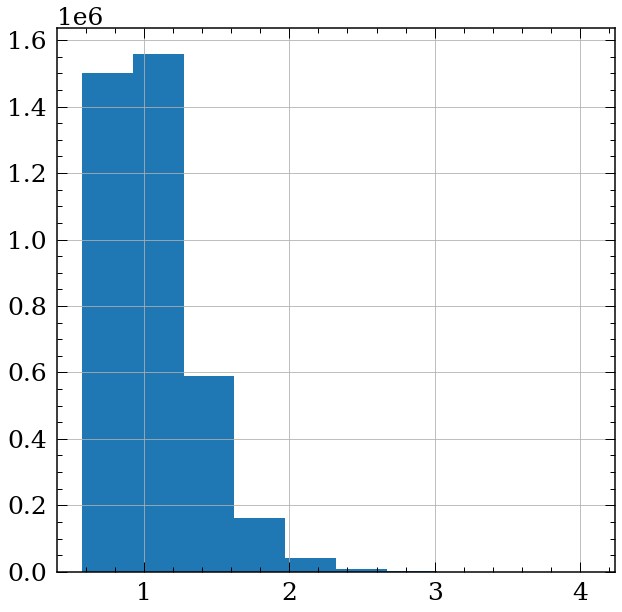

In [26]:
data.columns, len(data), max(data['age']), data['ecc'].hist()


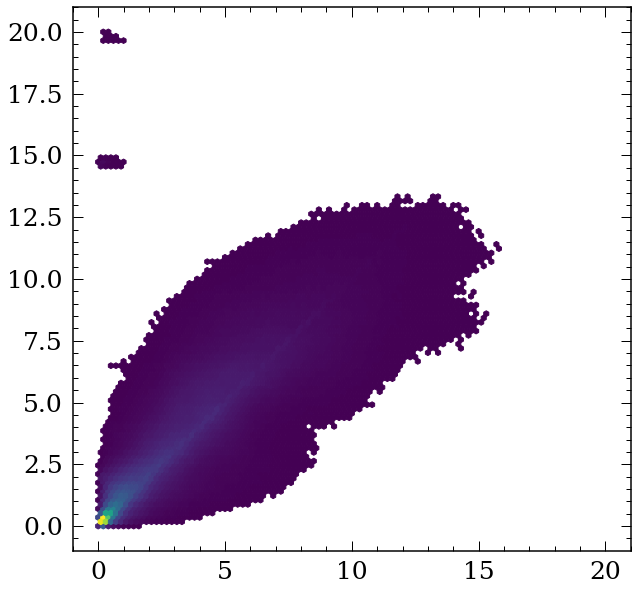

In [27]:
data['R'] = np.sqrt(data['x']**2+data['y']**2)

plt.hexbin(data['R'], data['rb'], 
          extent=(0,20,0,20), mincnt=100)



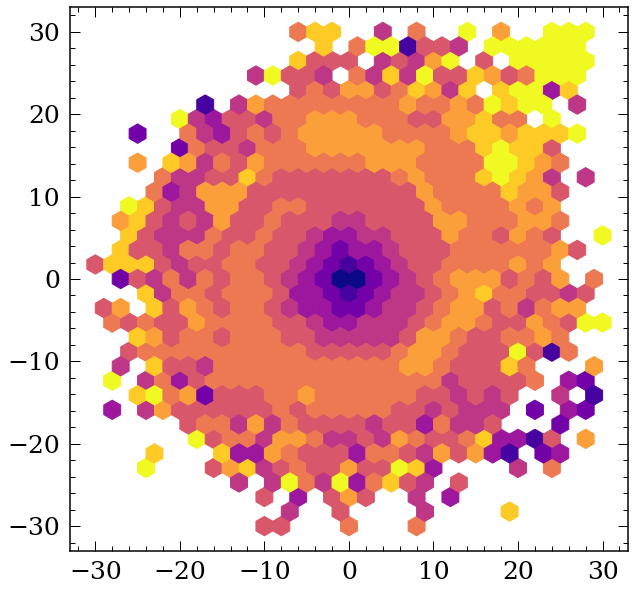

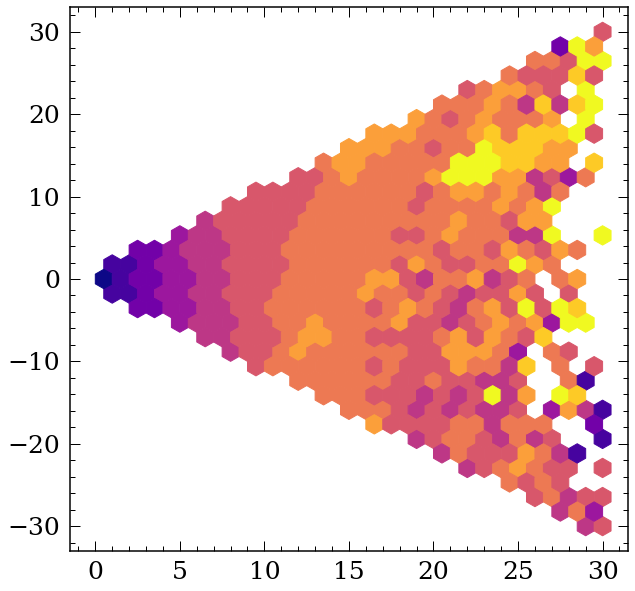

In [28]:

#data = data.loc[data['rb']<30]

rscale = 1

data['R'] = np.sqrt(data['x']**2+data['y']**2)*rscale
data['R_bir'] = data['rb']*rscale
data['x'] = data['x']*rscale
data['y'] = data['y']*rscale
data['z'] = data['z']*rscale
data['afe'] = data['mgfe']
#data['age'] = 13.8-data['age']
#data.to_pickle('Auriga.pkl')

plt.figure()
plt.hexbin(data['x'], data['y'], C=abs(data['R_bir']),
          extent=(-30,30,-30,30),vmin=0,vmax=15, mincnt=1,
           gridsize=30,cmap=plt.get_cmap('plasma',10))


plt.figure()
plt.hexbin(data['R'], data['z'], C=abs(data['R_bir']),
          extent=(0,30,-30,30),vmin=0,vmax=15, mincnt=1,
           gridsize=30,cmap=plt.get_cmap('plasma',10))


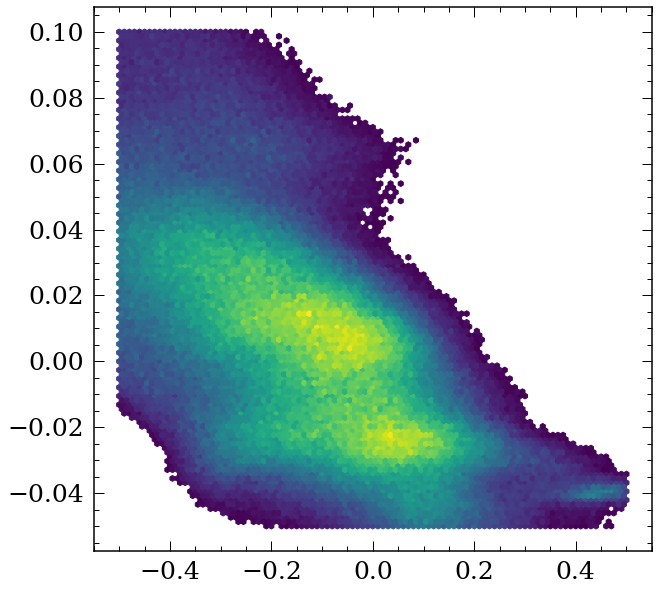

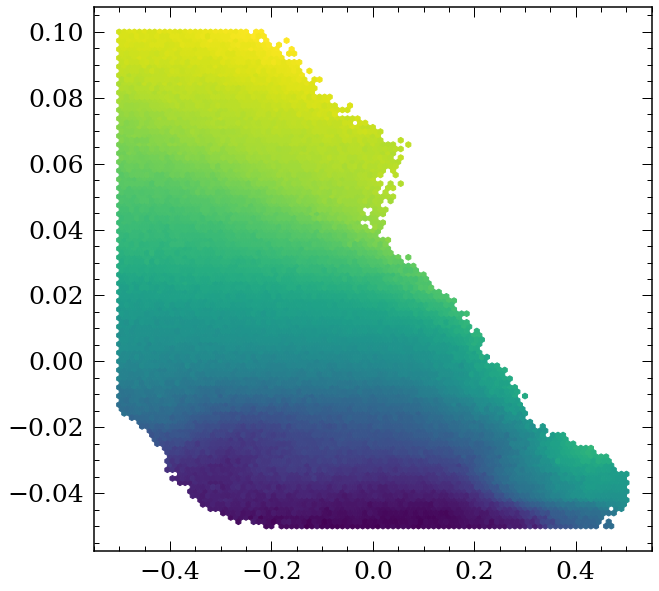

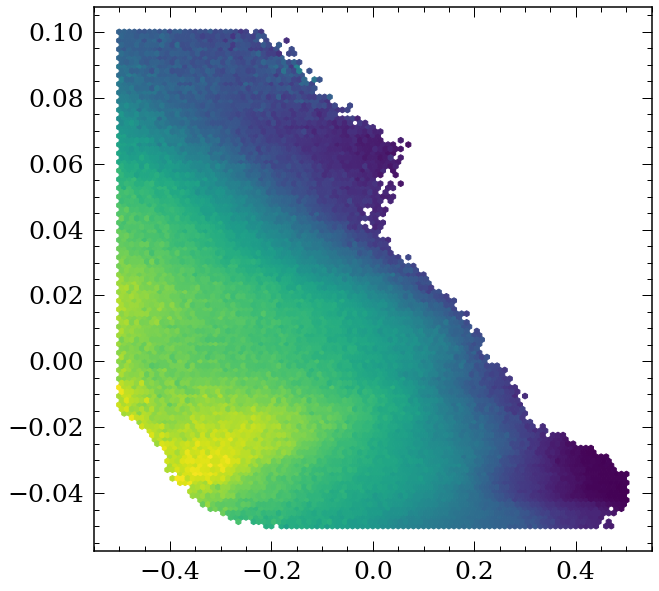

In [29]:
plt.figure()
plt.hexbin(data['feh'], data['afe'], extent=(-0.5, 0.5, -0.05, 0.1), mincnt=100)

plt.figure()
plt.hexbin(data['feh'], data['afe'], C=data['age'], 
           extent=(-0.5, 0.5, -0.05, 0.1), mincnt=100)

plt.figure()
plt.hexbin(data['feh'], data['afe'], C=data['R_bir'], 
           extent=(-0.5, 0.5, -0.05, 0.1), mincnt=100)



In [30]:
#m = ((data['age']-10)<0.5)&(((data['feh']+0.4)<0.1))
#plt.hist(data['R'][m],bins=np.linspace(0,10,100))

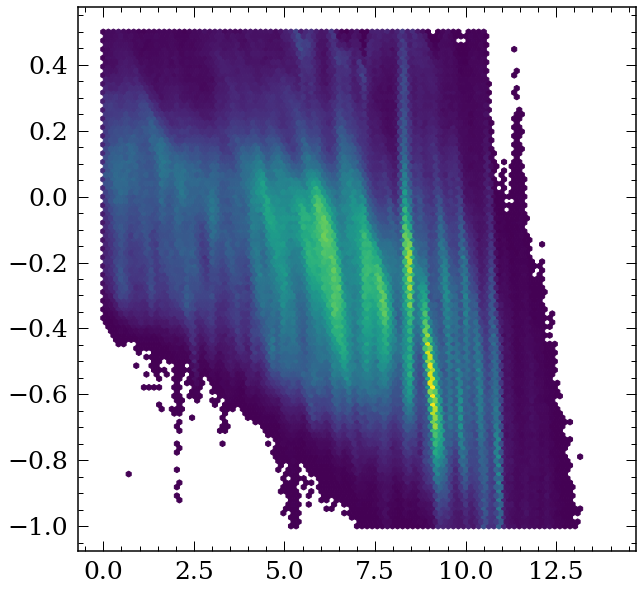

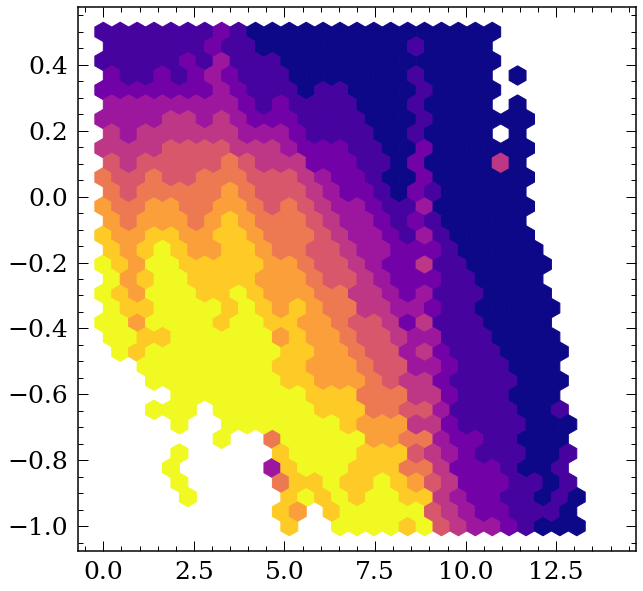

In [31]:
plt.figure()
plt.hexbin(data['age'], data['feh'], 
          extent=(0,14,-1,0.5),mincnt=1)


plt.figure()
plt.hexbin(data['age'], data['feh'], C=abs(data['R_bir']),
          extent=(0,14,-1,0.5),vmin=0,vmax=10, mincnt=1,
           gridsize=30,cmap=plt.get_cmap('plasma',10))



# Check simiulation with a bar

In [10]:
print(len(data))
data = data.loc[data['R_bir']<30]
data = data.loc[data['age']>=0]
print(len(data))

3880070
3862010


array([[<AxesSubplot:title={'center':'x'}>,
        <AxesSubplot:title={'center':'y'}>],
       [<AxesSubplot:title={'center':'z'}>, <AxesSubplot:>]], dtype=object)

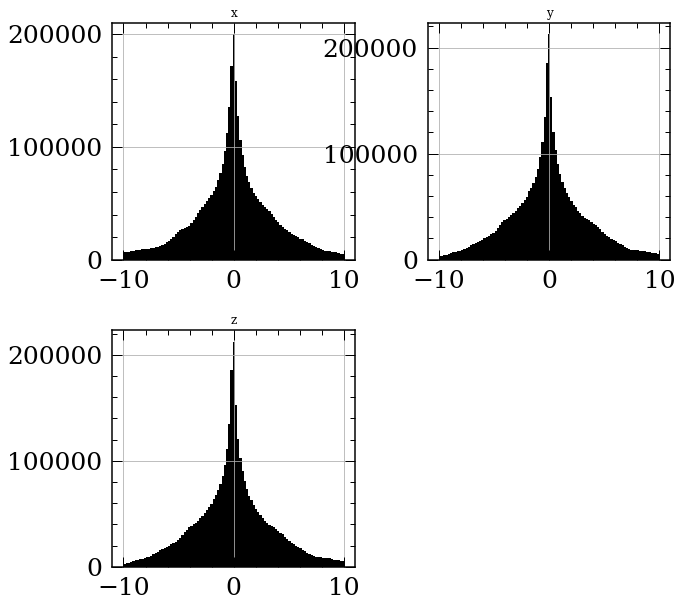

In [11]:

data[['x','y','z']].hist(bins=np.linspace(-10,10,100),
                        color='k')


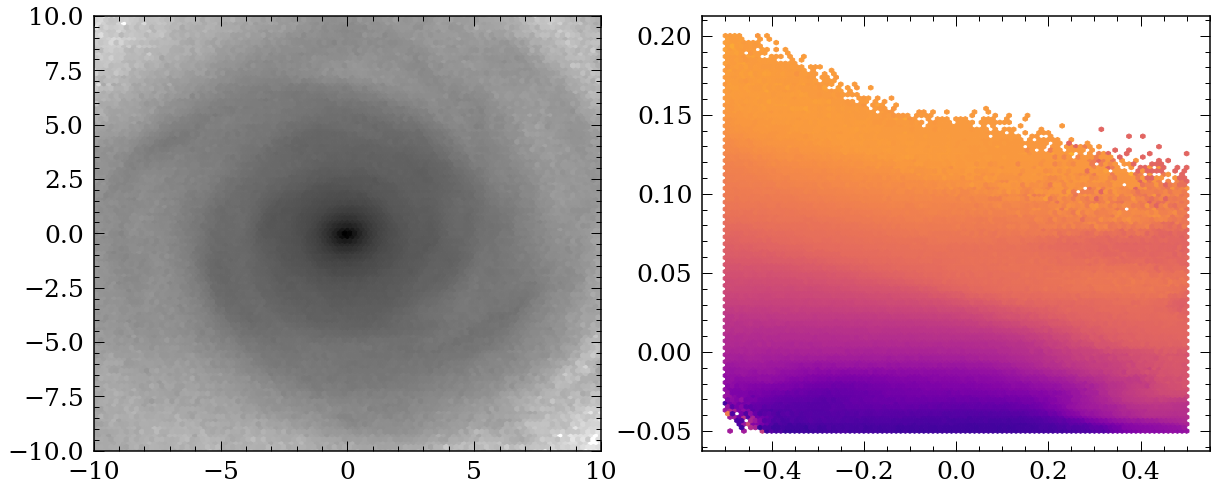

In [12]:

plt.figure(figsize=(20,8))
plt.subplot(1,2,1)
plt.hexbin(data['x'], data['y'], extent=(-10,10,-10,10),
          cmap='binary', bins='log')
plt.xlim([-10,10])
plt.ylim([-10,10])

plt.subplot(1,2,2)
plt.hexbin(data['feh'], data['afe'], C = data['age'],
           extent=(-0.5, 0.5, -0.05, 0.2),
          cmap='plasma', vmin=0, vmax=14)


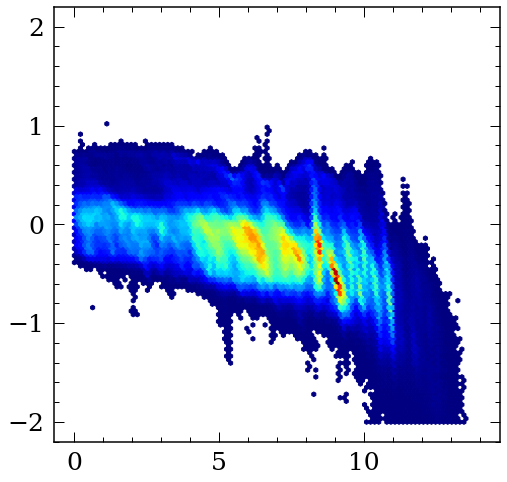

In [13]:
plt.figure(figsize=(8,8))
plt.hexbin(data['age'], data['feh'], extent=(0,14,-2,2),
          mincnt=1, cmap='jet')

In [14]:
def monoage_line_range(feh,r,age,agebin=np.linspace(0,14,8),xlims=[6,12],ylims=[-1.5,0.5],
                feherr=[],checkplt=True):
    colors = getcolor(range(len(agebin)+1))
    slopes = np.zeros(len(agebin)-1)
    fehscatter = np.zeros(len(agebin)-1)
    
    plt.figure(figsize=(20,8))
    for i in trange(len(agebin)-1):
        m = (age>agebin[i])&(age<agebin[i+1])
        if sum(m)==0:
            fehscatter[i] = np.nan
            continue
        r_sing, feh_sing = zip(*sorted(zip(r[m], feh[m])))
        r_sing, feh_sing = np.array(r_sing, dtype=float), np.array(feh_sing, dtype=float)
        
        m2 = (r_sing>xlims[0])&(r_sing<xlims[1])
        if sum(m2)==0:
            fehscatter[i] = np.nan
            continue
        
        p = fitpoints(r_sing[m2], feh_sing[m2]) 
        slopes[i] = p[1]
        
        fehscatter[i] = np.percentile(feh_sing[m2],95)-np.percentile(feh_sing[m2],5)
        fehmin = np.percentile(feh_sing[m2],5)
        fehmax = np.percentile(feh_sing[m2],95)
        
        #fehmin = min(feh_sing[m2])
        #fehmax = max(feh_sing[m2])
        #fehscatter[i] = fehmax-fehmin
        
        #fehscatter[i] = np.std(feh_sing[m2])
        #fehmin = np.mean(feh_sing[m2])-fehscatter[i]
        #fehmax = np.mean(feh_sing[m2])+fehscatter[i]

        
        if checkplt:
            plt.figure(figsize=(8,8))
            plt.plot(r_sing[m2], feh_sing[m2], 'r.')
            plt.plot(r_sing[m2], p(r_sing[m2]), 'k-',
                    label='%.2f Rb+%.2f'%(p[1],p[0]))
            plt.plot(r_sing[m2],
                     np.ones(sum(m2))*fehmax, 'b-')
            plt.plot(r_sing[m2],
                     np.ones(sum(m2))*fehmin, 'b-')
            
            plt.xlabel('Rb [kpc]')
            plt.ylabel('[Fe/H]')
            plt.title('%.2f Gyr - %.2f Gyr'%(agebin[i],agebin[i+1]),
                     fontsize=25)
            plt.legend()
            
            
            
            
    return (agebin[:-1]+agebin[1:])/2, slopes, fehscatter


def monoage_line(feh,r,age,agebin=np.linspace(0,14,8),
                feherr=[],xlims=[0,25],checkplt=True):
    colors = getcolor(range(len(agebin)+1))
    slopes = np.zeros(len(agebin)-1)
    fehscatter = np.zeros(len(agebin)-1)
    

    for i in trange(len(agebin)-1):
        m = (age>agebin[i])&(age<agebin[i+1])
        if sum(m)==0:
            fehscatter[i] = np.nan
            continue
        r_sing, feh_sing = zip(*sorted(zip(r[m], feh[m])))
        r_sing, feh_sing = np.array(r_sing, dtype=float), np.array(feh_sing, dtype=float)
        
        m2 = (r_sing>xlims[0])&(r_sing<xlims[1])
        if sum(m2)==0:
            fehscatter[i] = np.nan
            continue
        p = fitpoints(r_sing[m2], feh_sing[m2]) 
        slopes[i] = p[1]
        fehscatter[i] = np.std(feh_sing[m2]-p(r_sing[m2]))
        if len(feherr)>0:
            fehscatter[i] = np.sqrt(fehscatter[i]**2-np.mean(feherr[m][m2])**2)
            #print(np.std(feh_sing[m2]-p(r_sing[m2])))
        if checkplt:
            plt.figure(figsize=(8,8))
            plt.plot(r_sing[m2], feh_sing[m2], 'r.')
            plt.plot(r_sing[m2], p(r_sing[m2]), 'k-',
                    label='%.2f Rb+%.2f'%(p[1],p[0]))
            plt.plot([0,15], [np.percentile(feh_sing[m2],95),np.percentile(feh_sing[m2],95)],'b-')
            plt.plot([0,15], [np.percentile(feh_sing[m2],5),np.percentile(feh_sing[m2],5)],'b-')
            plt.plot([np.percentile(r_sing[m2],95),np.percentile(r_sing[m2],95)], [-3,0.5],'b-')
            plt.plot([np.percentile(r_sing[m2],5),np.percentile(r_sing[m2],5)], [-3,0.5],'b-')
            
            plt.xlabel('Rb [kpc]')
            plt.ylabel('[Fe/H]')
            plt.title('%.2f Gyr - %.2f Gyr'%(agebin[i],agebin[i+1]),
                     fontsize=25)
            plt.legend()

    return (agebin[:-1]+agebin[1:])/2, slopes, fehscatter
"""def monoage_line_range_med(feh,r,age,agebin=np.linspace(0,14,8),xlims=[6,12],ylims=[-1.5,0.5],
                feherr=[],checkplt=True):
    colors = getcolor(range(len(agebin)+1))
    slopes = np.zeros(len(agebin)-1)
    fehscatter = np.zeros(len(agebin)-1)
    
    plt.figure(figsize=(20,8))
    for i in trange(len(agebin)-1):
        m = (age>agebin[i])&(age<agebin[i+1])
        if sum(m)==0:
            fehscatter[i] = np.nan
            continue
        r_sing, feh_sing = zip(*sorted(zip(r[m], feh[m])))
        r_sing, feh_sing = np.array(r_sing, dtype=float), np.array(feh_sing, dtype=float)
        
        m2 = (r_sing>xlims[0])&(r_sing<xlims[1])
        if sum(m2)==0:
            fehscatter[i] = np.nan
            continue
        
        r_sing, feh_sing = r_sing[m2], feh_sing[m2]
        
        mov_r, mov_feh = movingMed_time(r_sing, feh_sing, 0.1, 0.5) 
        movint = interp1d(mov_r, mov_feh)
        
        m2 = (r_sing>min(mov_r))&(r_sing<max(mov_r))
        
        m3 = (feh_sing[m2]>movint(r_sing[m2]))
        
        fehmin = np.percentile(feh_sing[m2][m3], 80)
        fehmax = np.percentile(feh_sing[m2][~m3], 20)
        fehscatter[i] = fehmax-fehmin
        #fehscatter[i] = np.std(feh_sing[m2])
        
        if checkplt:
            plt.figure(figsize=(8,8))
            plt.plot(r_sing[m2], feh_sing[m2], 'r.')
            plt.plot(mov_r, mov_feh, 'k-')
            plt.plot(r_sing[m2],
                     np.ones(sum(m2))*fehmax, 'b-')
            plt.plot(r_sing[m2],
                     np.ones(sum(m2))*fehmin, 'b-')
            
            plt.xlabel('Rb [kpc]')
            plt.ylabel('[Fe/H]')
            plt.title('%.2f Gyr - %.2f Gyr'%(agebin[i],agebin[i+1]),
                     fontsize=25)
            plt.legend()
            
            
            
            
    return (agebin[:-1]+agebin[1:])/2, slopes, fehscatter"""

"def monoage_line_range_med(feh,r,age,agebin=np.linspace(0,14,8),xlims=[6,12],ylims=[-1.5,0.5],\n                feherr=[],checkplt=True):\n    colors = getcolor(range(len(agebin)+1))\n    slopes = np.zeros(len(agebin)-1)\n    fehscatter = np.zeros(len(agebin)-1)\n    \n    plt.figure(figsize=(20,8))\n    for i in trange(len(agebin)-1):\n        m = (age>agebin[i])&(age<agebin[i+1])\n        if sum(m)==0:\n            fehscatter[i] = np.nan\n            continue\n        r_sing, feh_sing = zip(*sorted(zip(r[m], feh[m])))\n        r_sing, feh_sing = np.array(r_sing, dtype=float), np.array(feh_sing, dtype=float)\n        \n        m2 = (r_sing>xlims[0])&(r_sing<xlims[1])\n        if sum(m2)==0:\n            fehscatter[i] = np.nan\n            continue\n        \n        r_sing, feh_sing = r_sing[m2], feh_sing[m2]\n        \n        mov_r, mov_feh = movingMed_time(r_sing, feh_sing, 0.1, 0.5) \n        movint = interp1d(mov_r, mov_feh)\n        \n        m2 = (r_sing>min(mov_r))&(r_sing<ma

In [15]:
print(max(data['age']))

13.601692199707031


<AxesSubplot:>

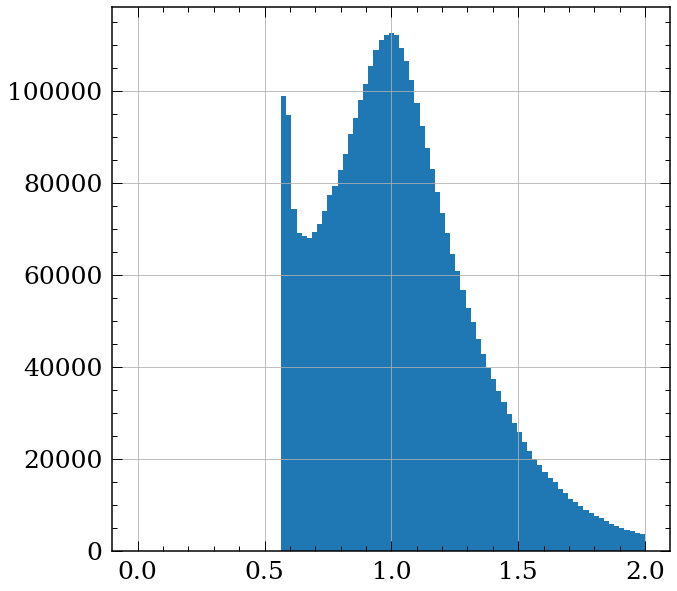

In [45]:
data['ecc'].hist(bins=np.linspace(0,2,100))

100%|██████████| 29/29 [01:39<00:00,  3.44s/it]


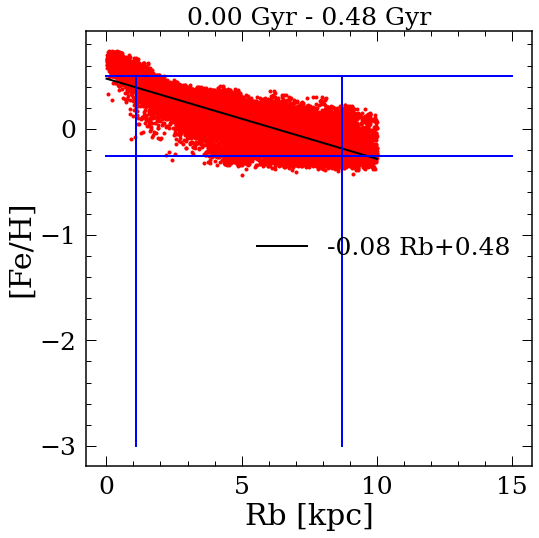

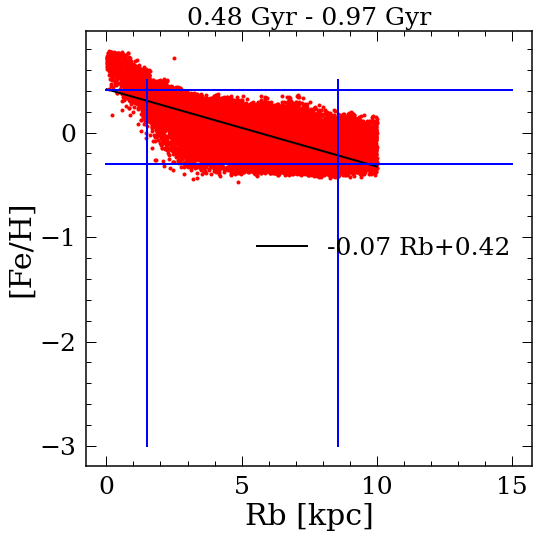

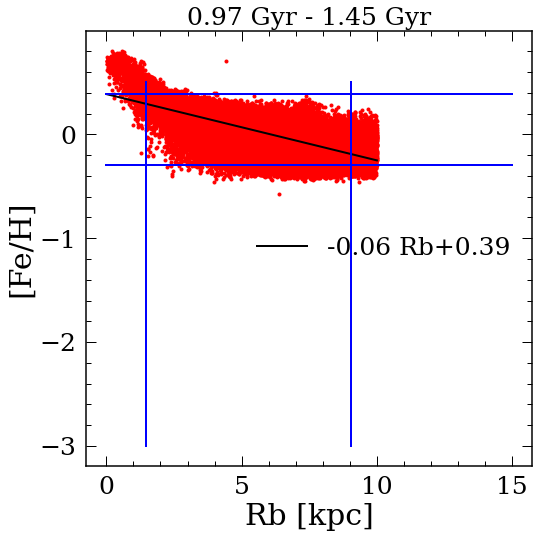

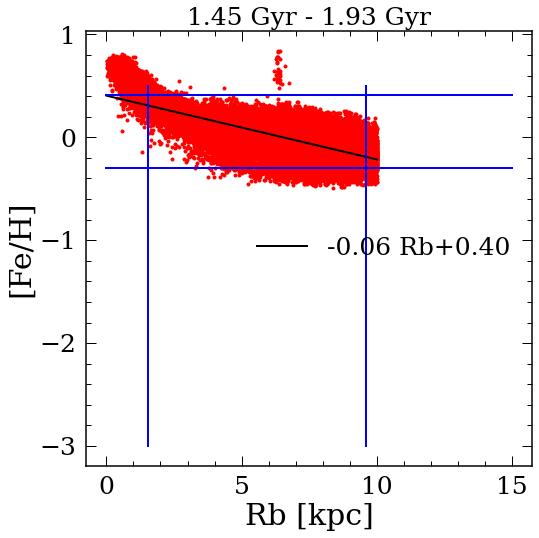

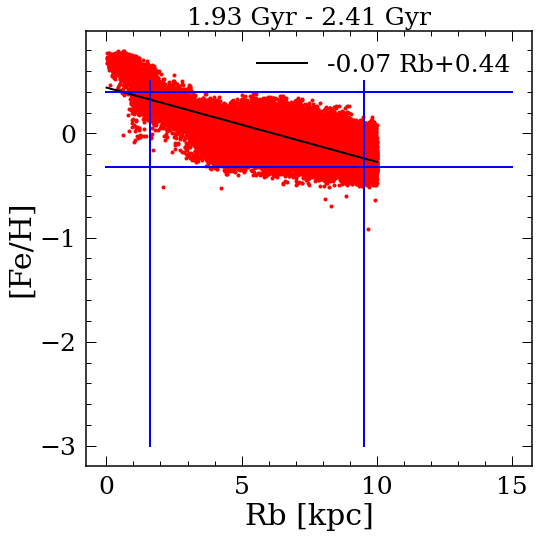

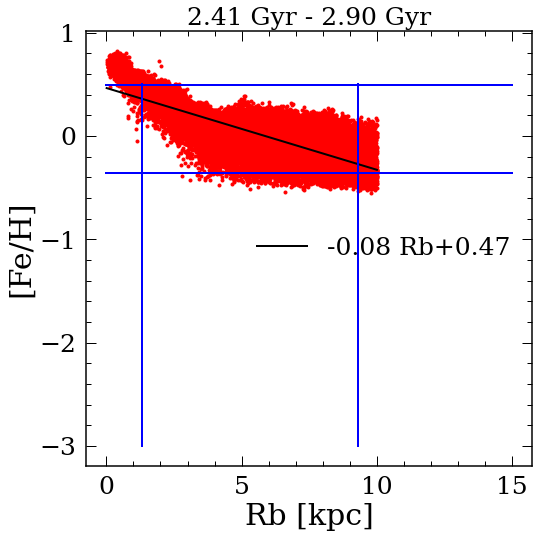

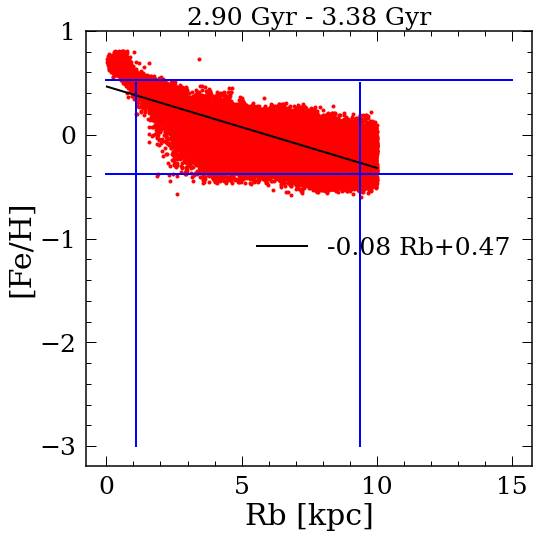

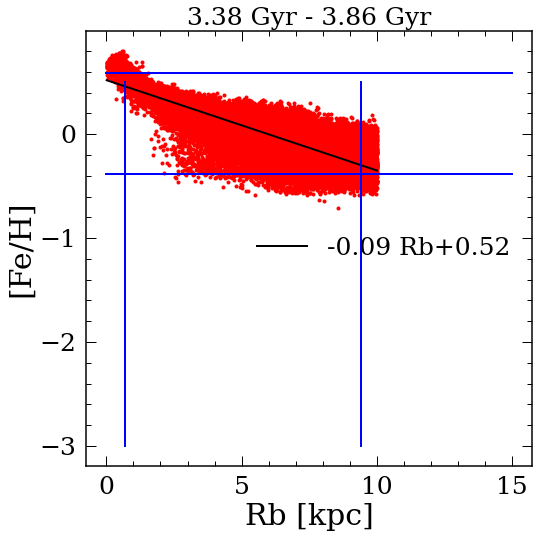

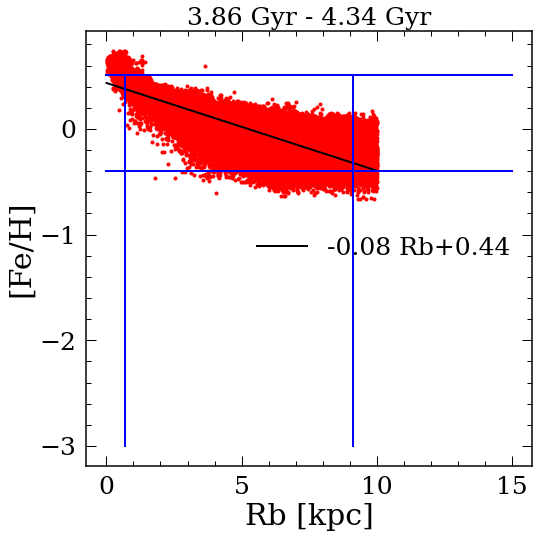

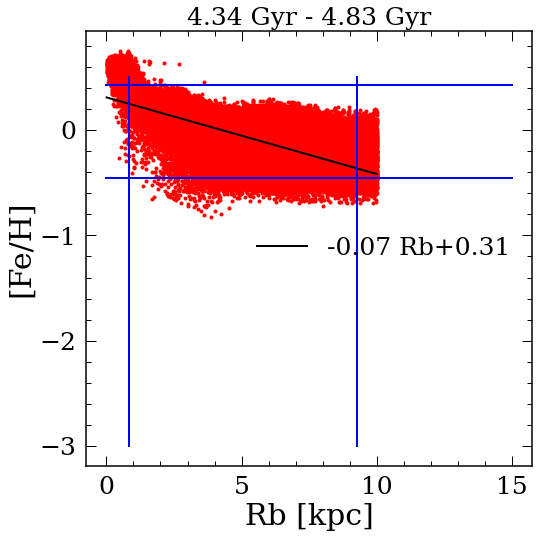

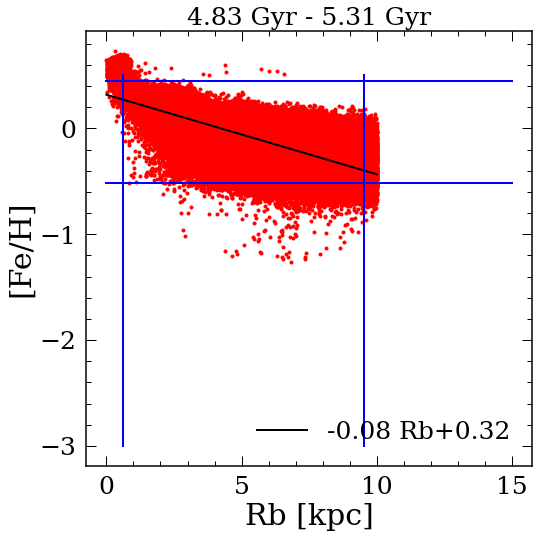

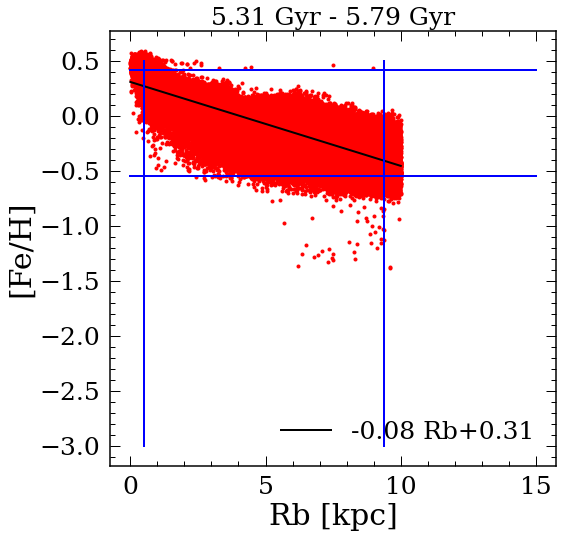

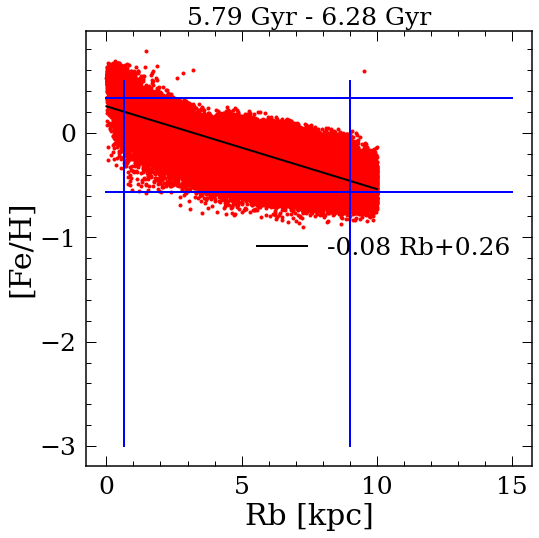

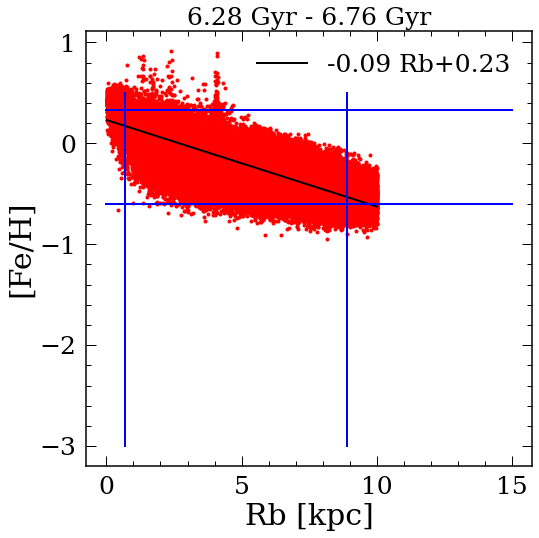

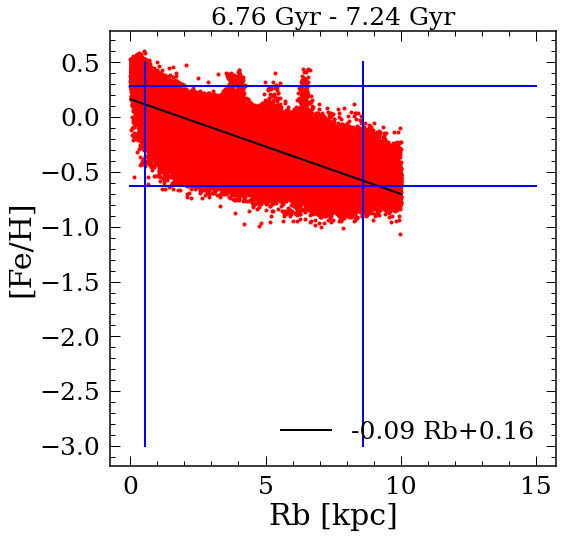

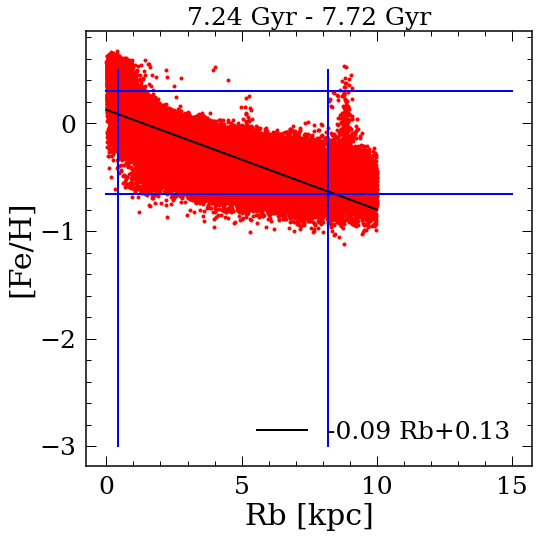

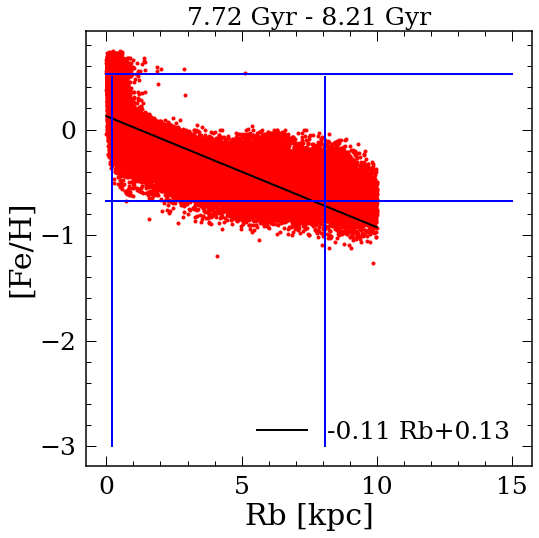

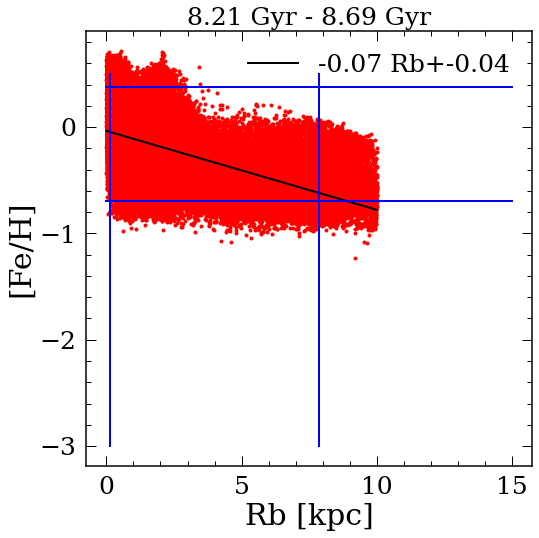

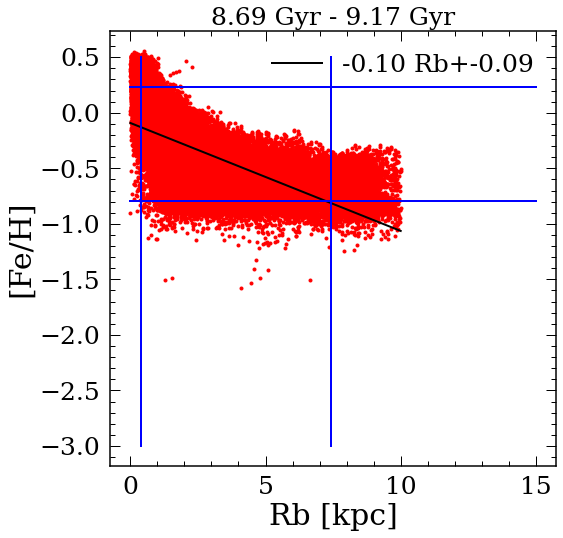

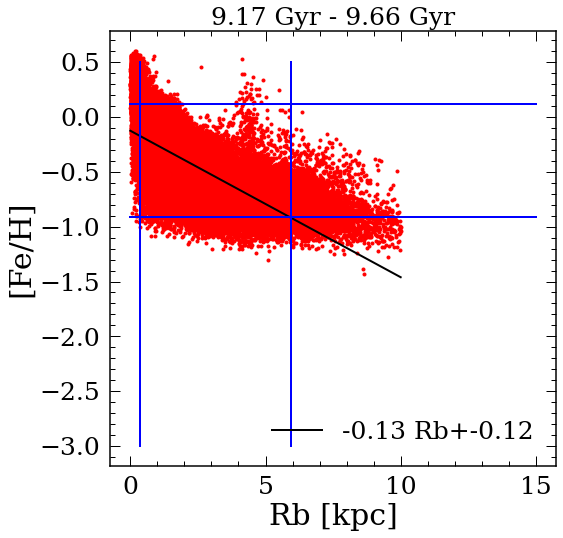

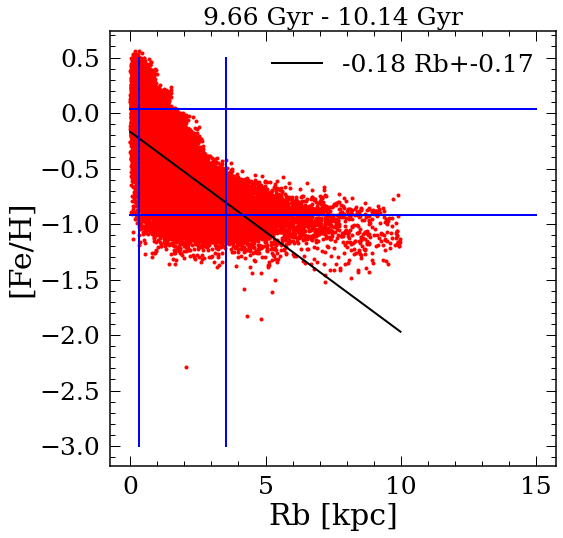

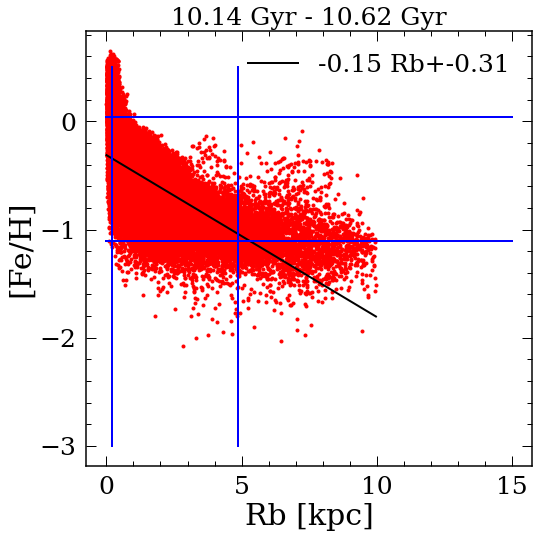

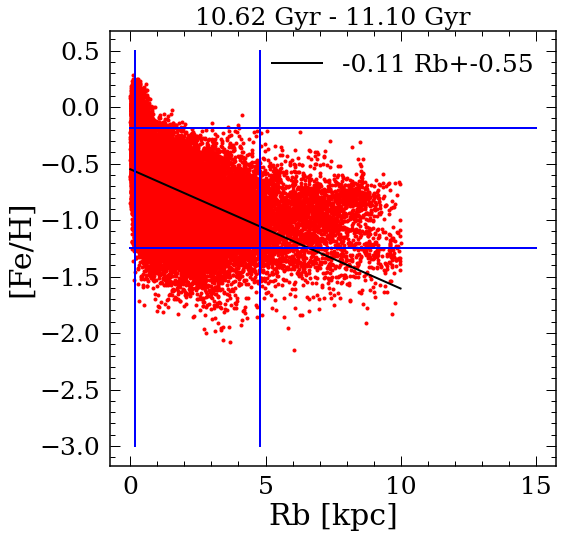

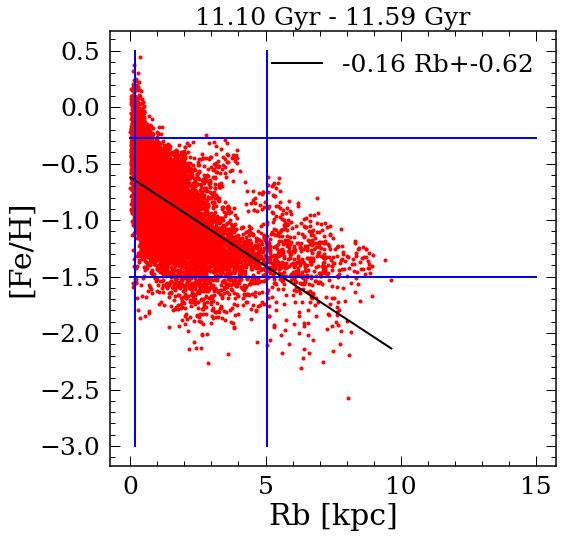

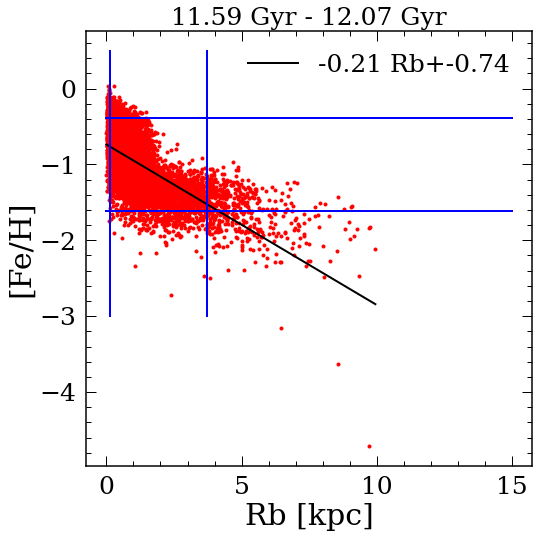

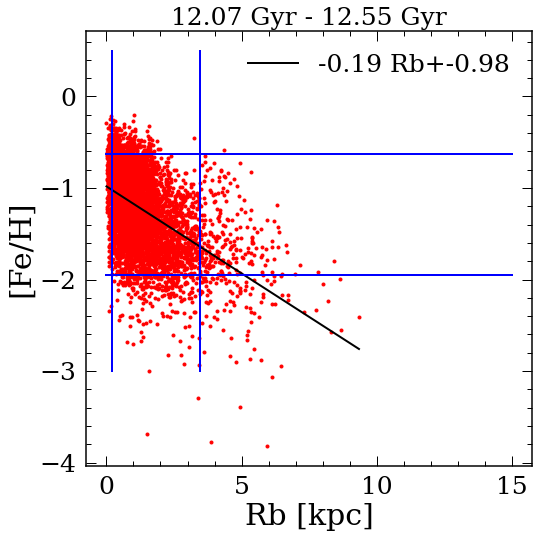

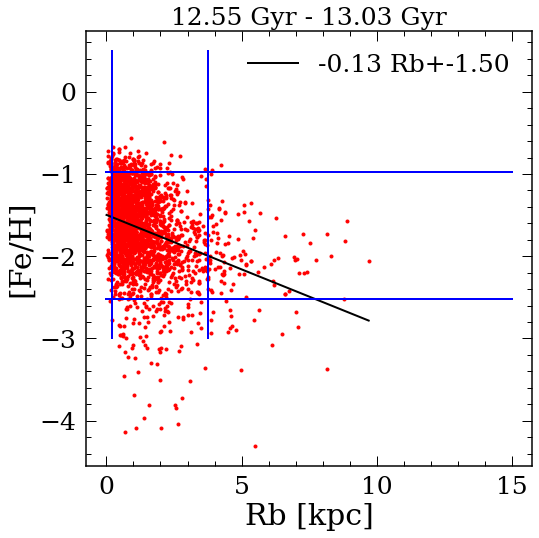

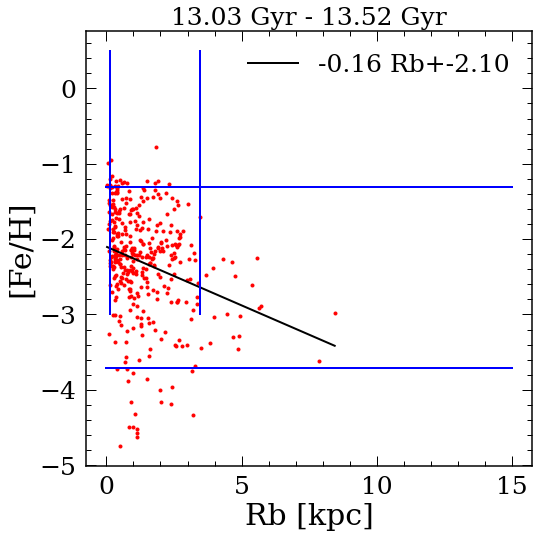

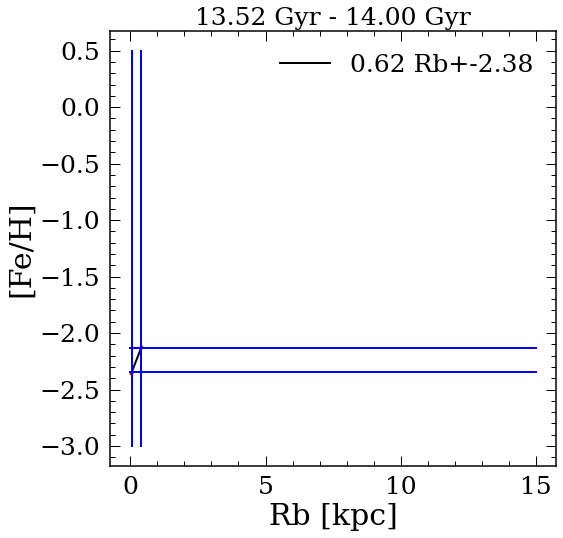

In [46]:
data_calc = data.loc[data['ecc']<1].reset_index(drop=True)
data_calc['age_new'] = [np.random.normal(i, 0.5) for i in data_calc['age']]
data_calc['feh_new'] = [np.random.normal(i, 0.03) for i in data_calc['feh']]



m = (data_calc['feh']>-5)
#m = m&(data_calc['R_bir']>0)
#m = m&(data_calc['R_bir']<10)

ages, slopes_rbir, fehscatter_rbir = monoage_line(data_calc['feh'].values[m], 
                                        data_calc['R_bir'].values[m], 
                                        data_calc['age'].values[m],
                                        agebin=np.linspace(0,14,30),
                                                 xlims=[0,10])


In [48]:
import warnings
warnings.filterwarnings('ignore')

xlims = [7,10]
m = (data_calc['R']>xlims[0])&(data_calc['R']<xlims[1])

fehscatter = np.zeros((29,2))

for i in range(2):
    data_calc['age_new'] = [np.random.normal(i, 0.5) for i in data_calc['age']]
    data_calc['feh_new'] = [np.random.normal(i, 0.03) for i in data_calc['feh']]
    ages, slopes, fehscatter[:,i] = monoage_line_range(data_calc['feh_new'].values[m], 
                                        data_calc['R'].values[m], 
                                        data_calc['age_new'].values[m],
                                        agebin=np.linspace(0,14,30),
                                        xlims=[7,10],ylims=[-2,2],
                                         checkplt=False)



100%|██████████| 29/29 [00:13<00:00,  2.21it/s]


<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

In [49]:

fehscatter_err = np.array([np.std(fehscatter[i,:]) for i in range(29)], dtype=float)
fehscatter_f = np.array([np.mean(fehscatter[i,:]) for i in range(29)], dtype=float)




In [50]:
fehscatter_f, slopes_rbir

(array([0.4662108 , 0.48254724, 0.49946282, 0.51009152, 0.52729576,
        0.54979635, 0.56295628, 0.57006854, 0.58937483, 0.61735041,
        0.63237507, 0.64269951, 0.63908479, 0.62401694, 0.61887126,
        0.62246237, 0.62927618, 0.66777292, 0.70479572, 0.69215568,
        0.79789008, 0.88695291, 0.96292401, 1.10032836, 1.26320773,
        1.4254251 , 1.61000676, 2.22224907, 1.78424876]),
 array([-0.07593367, -0.07402625, -0.06380667, -0.06201539, -0.07138167,
        -0.07920703, -0.07854401, -0.08693856, -0.08307289, -0.07276426,
        -0.07520946, -0.07631113, -0.07934198, -0.08583653, -0.08642674,
        -0.09273926, -0.10527594, -0.07424031, -0.09726168, -0.13367732,
        -0.18026226, -0.14967573, -0.10570728, -0.15711389, -0.21175458,
        -0.19030781, -0.13261884, -0.15576689,  0.61851844]))

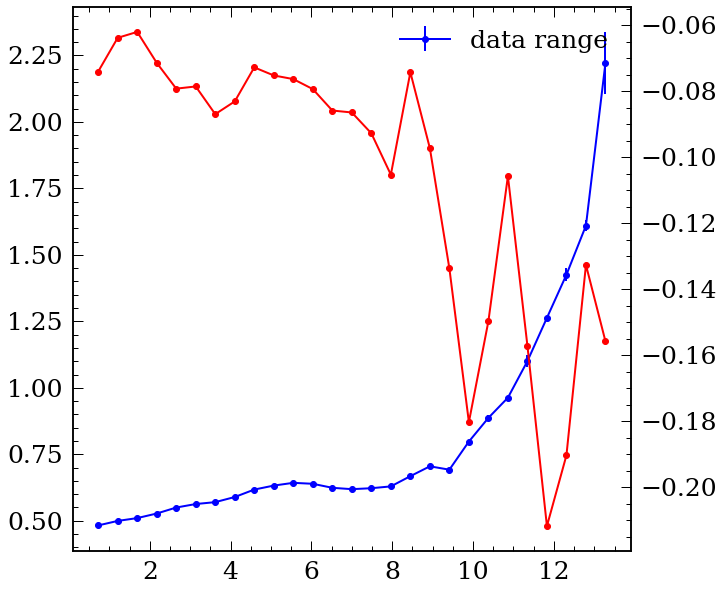

In [56]:
m = (ages>0.5)&(ages<13.5)
plt.errorbar(ages[m], (fehscatter_f)[m], yerr=fehscatter_err[m],
             fmt = 'b-o', label='data range')
#plt.plot(ages[m], (intin(ages[m])-intout(ages[m])), 'b-o', label='actual range')
plt.legend(loc=1)
plt.twinx()
plt.plot(ages[m], slopes_rbir[m], 'r-o', label='birth slope')
#plt.legend(loc=2)

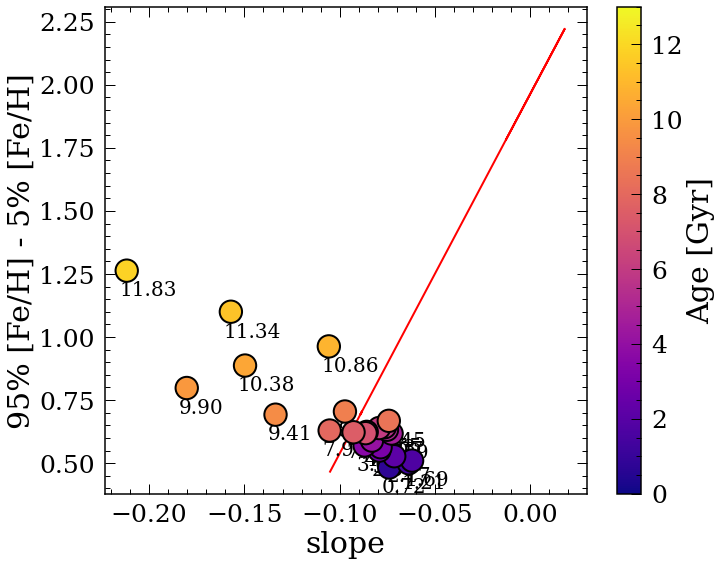

In [54]:
#diskint = interp1d(13.8-m2pattern['time'],m2pattern['half_mass_l2'])

import scipy
plt.figure(figsize=(10,8))
plt.scatter(slopes_rbir[m], 
         fehscatter_f[m],c=ages[m],
           s=500, edgecolor='k', linewidth=2,
           vmin=0, vmax=13, cmap='plasma',zorder=10)
plt.xlabel('slope')
plt.ylabel('95% [Fe/H] - 5% [Fe/H]')
cb = plt.colorbar()
cb.set_label('Age [Gyr]')
n = ages[m]
for i, txt in enumerate(n):
    plt.annotate('%.2f'%txt, (slopes_rbir[m][i]-0.004, fehscatter_f[m][i]-0.1), 
                 fontsize=20,color='k')
plt.tight_layout()

#plt.title('Data [Fe/H] Range', fontsize=25)

p = fitpoints(fehscatter_f, slopes_rbir)
plt.plot(p(fehscatter_f), fehscatter_f, 'r')
slopesinf = p(fehscatter_f)

In [451]:
pd.DataFrame(np.array((ages, slopes, fehscatter_f,fehscatter_err, slopes_rbir, fehscatter_rbir,
                      slopesinf)).T,
            columns=['age', 'slopes', 'fehscatter','fehscatter_err', 
                     'slopes_rbir', 'fehscatter_rbir',
       'sloperb_inf']).to_csv('HESTIA.csv')

In [417]:
#m = (ages<7)
#plt.plot((intin(ages[m])-intout(ages[m])-fehscatter[m]), 'ko')
#plt.plot((intin(ages[m])-intout(ages[m])-fehscatter[m])*np.exp(0.4*ages[m]), 'ro')

(-0.9341527658500208, 8.723080053122706e-06)

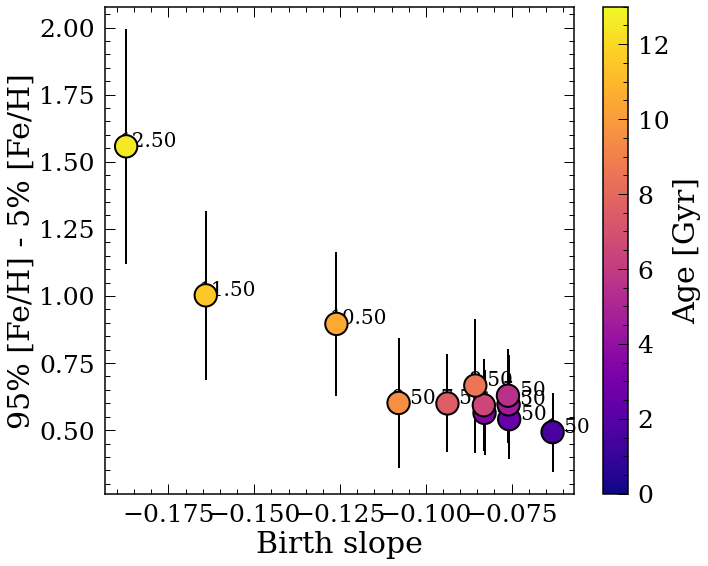

In [418]:
#diskint = interp1d(13.8-m2pattern['time'],m2pattern['half_mass_l2'])

import scipy
plt.figure(figsize=(10,8))
plt.scatter(slopes_rbir[m], 
         fehscatter[m],c=ages[m],
           s=500, edgecolor='k', linewidth=2,
           vmin=0, vmax=13, cmap='plasma',zorder=10)
plt.errorbar(slopes_rbir[m], 
         fehscatter[m],
             yerr=fehscatter_rbir[m], fmt='ko',
            zorder=1)
plt.xlabel('Birth slope')
plt.ylabel('95% [Fe/H] - 5% [Fe/H]')
cb = plt.colorbar()
cb.set_label('Age [Gyr]')
n = ages[m]
for i, txt in enumerate(n):
    plt.annotate('%.2f'%txt, (slopes_rbir[m][i]-0.002, fehscatter[m][i]), 
                 fontsize=20,color='k')
plt.tight_layout()

#plt.title('Data [Fe/H] Range', fontsize=25)


#scipy.stats.pearsonr(slopes_rbir[m], (intin(ages[m])-intout(ages[m]))), scipy.stats.pearsonr(slopes_rbir[m], fehscatter[m])
scipy.stats.pearsonr(slopes_rbir[m], fehscatter[m])